In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


In [26]:
#Dataset loading
wine_dataframe = pd.read_csv('datatest.csv', index_col=0)
wine_dataframe = wine_dataframe.drop('URLS', axis=1)
wine_dataframe = wine_dataframe.drop('Tranquille to Mousseux', axis=1)
# Small adjustments concerning data types ,...
wine_dataframe['Léger to Puissant'] = wine_dataframe['Léger to Puissant'].str.replace(';', '')
wine_dataframe['Souple to Tannique'] = wine_dataframe['Souple to Tannique'].str.replace(';', '')
wine_dataframe['Sec to Moelleux'] = wine_dataframe['Sec to Moelleux'].str.replace(';', '')
wine_dataframe['Doux to Acide'] = wine_dataframe['Doux to Acide'].str.replace(';', '')
wine_dataframe['Léger to Puissant'] = wine_dataframe['Léger to Puissant'].astype(float)
wine_dataframe['Souple to Tannique'] = wine_dataframe['Souple to Tannique'].astype(float)
wine_dataframe['Sec to Moelleux'] = wine_dataframe['Sec to Moelleux'].astype(float)
wine_dataframe['Doux to Acide'] = wine_dataframe['Doux to Acide'].astype(float)


In [27]:
# Small adjustments concerning aromas
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.replace('/+', '+')
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.replace(',+', '+')
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.replace('/+', '+')
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.replace(',+', '+')
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.replace('Ã©', 'é')
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.replace('Ã‰', 'é')
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.replace('Ã©', 'é')
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.replace('Ã‰', 'é')
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.lower()
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.lower()
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.lstrip('+')
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.lstrip('+')
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.split('+')
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.split('+')

wine_dataframe['Aromas'] = wine_dataframe['Aromas'].apply(lambda x: [] if isinstance(x, float) else x)
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].apply(lambda x: [] if isinstance(x, float) else x)
print(wine_dataframe.describe())

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


       Léger to Puissant  Souple to Tannique  Sec to Moelleux  Doux to Acide
count       35218.000000        35218.000000     35218.000000   35218.000000
mean           39.965001           19.491293        19.386413      37.882006
std            29.311771           23.718340        15.306354      28.274971
min             0.000000            0.000000         0.000000       0.000000
25%             0.000000            0.000000         0.000000       0.000000
50%            51.000000            0.000000        23.578555      50.105424
75%            63.804147           40.940347        30.224412      59.500000
max            85.000000           85.000000        85.000000      85.000000


In [28]:
value_counts = wine_dataframe['Olphactive'].apply(lambda x: type(x).__name__).value_counts()
print(value_counts)

list    35218
Name: Olphactive, dtype: int64


In [29]:
from sklearn.preprocessing import MultiLabelBinarizer

# One hot encoding of all aromas

mlb = MultiLabelBinarizer()
Aromas_one_hot_encoded = mlb.fit_transform(wine_dataframe['Aromas'])
Aromas_df_encoded = pd.DataFrame(Aromas_one_hot_encoded, columns=mlb.classes_)
Olphactive_one_hot_encoded = mlb.fit_transform(wine_dataframe['Olphactive'])
Olphactive_df_encoded = pd.DataFrame(Olphactive_one_hot_encoded, columns=mlb.classes_)
df_concatenated_0 = pd.concat([wine_dataframe, Aromas_df_encoded], axis=1)
df_concatenated = pd.concat([df_concatenated_0, Olphactive_df_encoded], axis=1)

df_concatenated.drop('Aromas', axis=1, inplace=True)
df_concatenated.drop('Olphactive', axis=1, inplace=True)

# count the number of observations per variety
counts = df_concatenated['Cépages'].value_counts()

# print the counts
print(counts)

Pinot noir            8378
Cabernet-Sauvignon    8127
Chardonnay            8108
Riesling              3274
Merlot                3111
Malbec                1582
Sangiovese            1414
Zinfandel             1224
Name: Cépages, dtype: int64


In [30]:
# Removal of all obs with 4 "0" as continuous variables
for i, row in df_concatenated.iterrows():
    if row['Léger to Puissant'] == 0 and row['Souple to Tannique'] == 0 and row['Sec to Moelleux'] == 0 and row['Doux to Acide'] == 0:
        df_concatenated = df_concatenated.drop(i) 

In [31]:
# Current dataset , actually the same as in data.csv
print(df_concatenated['Cépages'].value_counts())

Pinot noir            5888
Chardonnay            5633
Cabernet-Sauvignon    4405
Riesling              2820
Merlot                2209
Malbec                1263
Zinfandel              940
Sangiovese             790
Name: Cépages, dtype: int64


In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X = df_concatenated.drop('Cépages', axis=1)
y = df_concatenated['Cépages']

# Separation between train and test sets, no need for a validation since we will use GridSearch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

In [33]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 2) PREDICT

In [34]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'max_features': ['auto', 'sqrt']
}
from sklearn.model_selection import GridSearchCV

In [38]:
from sklearn.metrics import classification_report

# Building a random forest model
rf = RandomForestClassifier()

# Fitting and predicting with GridSearch
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred))

hello
                    precision    recall  f1-score   support

Cabernet-Sauvignon       0.87      0.92      0.89       460
        Chardonnay       0.96      0.98      0.97       558
            Malbec       0.79      0.73      0.76       120
            Merlot       0.85      0.82      0.83       227
        Pinot noir       0.97      0.96      0.96       589
          Riesling       0.97      0.97      0.97       278
        Sangiovese       0.89      0.65      0.75        75
         Zinfandel       0.92      0.91      0.91        88

          accuracy                           0.92      2395
         macro avg       0.90      0.87      0.88      2395
      weighted avg       0.92      0.92      0.92      2395



In [39]:
print('Best hyperparameters:', grid_search.best_params_)
print('Accuracy score:', grid_search.best_score_)


Best hyperparameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 300}
Accuracy score: 0.924140371498799


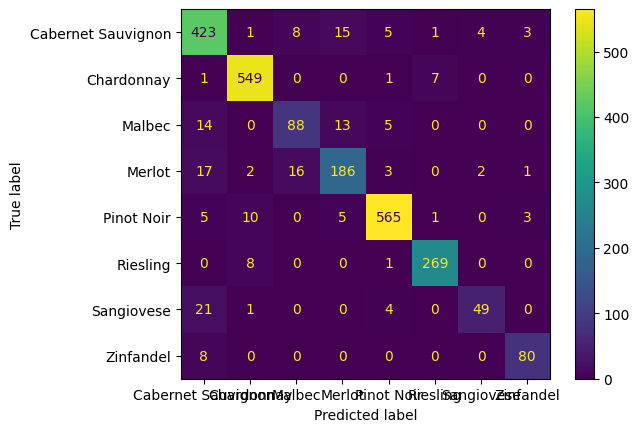

In [40]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Cabernet Sauvignon" , "Chardonnay","Malbec","Merlot","Pinot Noir","Riesling","Sangiovese","Zinfandel"])

cm_display.plot()
plt.show()

In [18]:
print(type(X))
X_train = pd.DataFrame(X_train, columns = X.columns)

X_test = pd.DataFrame(X_test, columns=X.columns)

<class 'pandas.core.frame.DataFrame'>


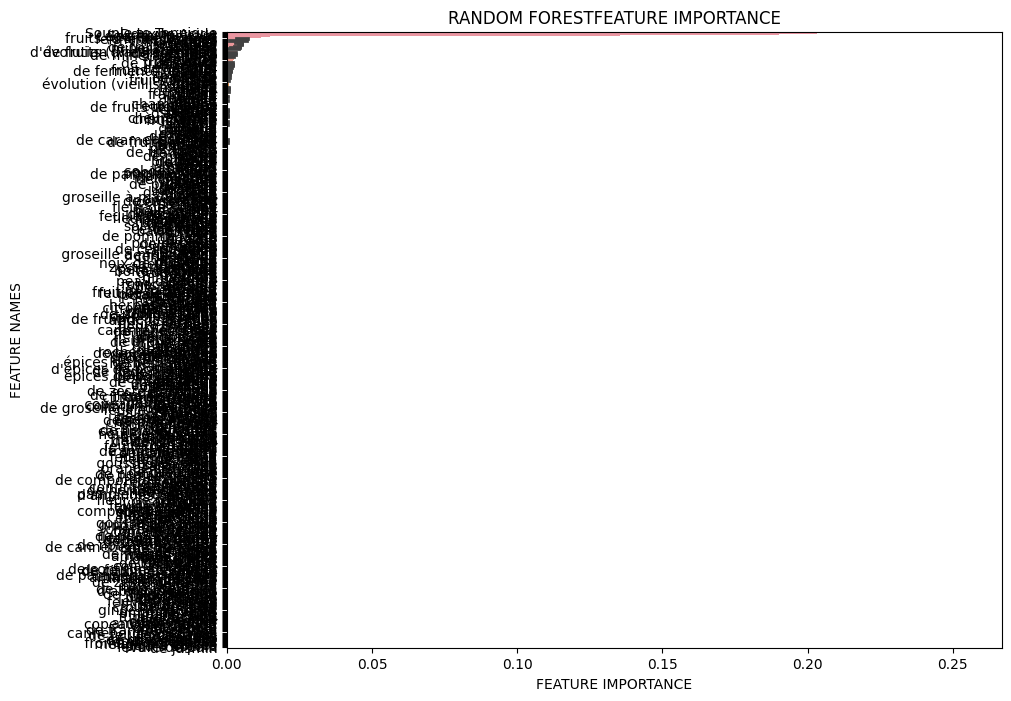

In [21]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
plot_feature_importance(rf.feature_importances_,X_train.columns,'RANDOM FOREST')
plt.show()